In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro, norm

import os
scores_df = pd.read_parquet(os.path.expanduser('~/smolmodels/data/scored_sorted_logprobs.parquet'))
scores_df.describe()

In [ ]:
scores_df = scores_df[
    [
        "chosen_logps",
        "rejected_logps",
        "mean_chosen_logits",
        "mean_rejected_logits",
    ]
]
scores_df['logprobs_diff'] = scores_df['chosen_logps'] - scores_df['rejected_logps']
scores_df['logits_diff'] = scores_df['mean_chosen_logits'] - scores_df['mean_rejected_logits']
scores_df.hist(bins=100, figsize=(20, 10))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

for i, col in enumerate(["logprobs_diff", "logits_diff"]):
    mean, std = scores_df[col].mean(), scores_df[col].std()
    stat, p = shapiro(scores_df[col])
    print(f"Shapiro-Wilk score: {stat}, p-value: {p}")
    print(f"{col} mean: {mean}, std: {std}")
    pdf_bins = [10, 50, 90, 100]
    pdf_labels = ['10-50', '50-90', '90-100']
    percentile_bins = norm.ppf([x/100 for x in pdf_bins], loc=mean, scale=std)
    print(f"{col} 10th, 50th, 90th percentiles: {percentile_bins}")
    scores_df[f"{col}_percentile_idx"] = pd.cut(scores_df[col], bins=percentile_bins, labels=pdf_labels, include_lowest=True, right=True)
    axs[i].hist(scores_df[col], bins=100)
    axs[i].axvline(mean, color='r', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean + std, color='r', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean - std, color='r', linestyle='dashed', linewidth=1)
    axs[i].set_title(col)

In [ ]:
scores_df.logprobs_diff.hist(bins=100)

logprobs_diff 10th, 50th, 90th percentiles: [-396.65851039  -56.6566293   283.3452518            inf]


0        27641.0
1        31591.5
2        26147.0
3        33244.5
4         9974.0
          ...   
54820    16482.5
54821    32085.0
54822    29759.0
54823    25398.5
54824    54022.0
Name: logprobs_diff_rank_sorted, Length: 54825, dtype: float64

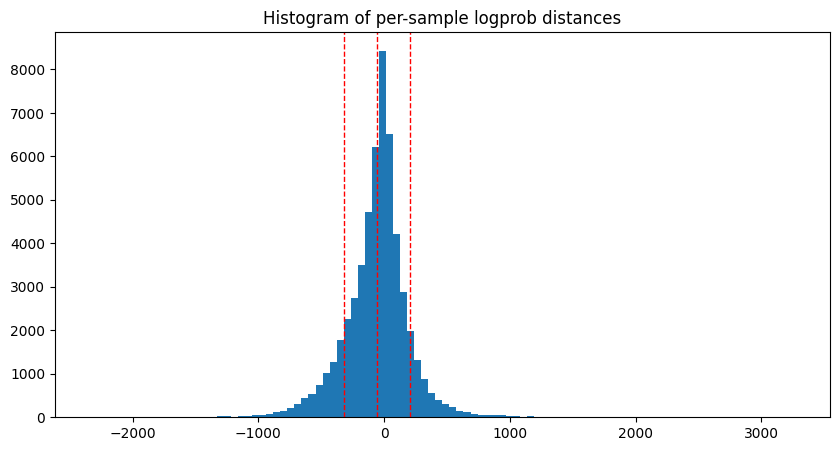

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

col = "logprobs_diff"
mean, std = scores_df[col].mean(), scores_df[col].std()
pdf_bins = [10, 50, 90, 100]
pdf_labels = ['10-50', '50-90', '90-100']
percentile_bins = norm.ppf([x/100 for x in pdf_bins], loc=mean, scale=std)
print(f"{col} 10th, 50th, 90th percentiles: {percentile_bins}")
scores_df[f"{col}_percentile_idx"] = pd.cut(scores_df[col], bins=percentile_bins, labels=pdf_labels, include_lowest=True, right=True) # type: ignore
ax.hist(scores_df[col], bins=100)
ax.axvline(mean, color='r', linestyle='dashed', linewidth=1)
ax.axvline(mean + std, color='r', linestyle='dashed', linewidth=1)
ax.axvline(mean - std, color='r', linestyle='dashed', linewidth=1)
ax.set_title("Histogram of per-sample logprob distances")
scores_df['logprobs_diff_rank_sorted']